# Rock Paper Scissors - Agents Comparison 

This notebook contains a lot of different agents from different sources.    
In the **Comparison In Battle** section, we also added a comparison in a fair battle of each agent with each in 1 round with 1000 steps.

## Agent: Hit The Last Own Action

The idea of the agent:

- A lot of agents use a simple baseline - copy the last action of the opponent.   
- That's why we can simply hit our last actions (new action of the opponent)

In [1]:
%%writefile submission/hit_the_last_own_action.py

my_last_action = 0

def hit_the_last_own_action(observation, configuration):
    global my_last_action
    my_last_action = (my_last_action + 1) % 3
    
    return my_last_action

Overwriting submission/hit_the_last_own_action.py


## Agent: Rock

Copy from: https://github.com/Kaggle/kaggle-environments/blob/master/kaggle_environments/envs/rps/agents.py    

Always uses Rock action

In [2]:
%%writefile submission/rock.py

def rock(observation, configuration):
    return 0

Overwriting submission/rock.py


## Agent: Paper

Copy from: https://github.com/Kaggle/kaggle-environments/blob/master/kaggle_environments/envs/rps/agents.py

Always uses Paper action

In [3]:
%%writefile submission/paper.py

def paper(observation, configuration):
    return 1


Overwriting submission/paper.py


## Agent: Scissors

Copy from: https://github.com/Kaggle/kaggle-environments/blob/master/kaggle_environments/envs/rps/agents.py

Always uses Scissors action

In [4]:
%%writefile submission/scissors.py

def scissors(observation, configuration):
    return 2

Overwriting submission/scissors.py


## Agent: Copy Opponent

Copy from: https://github.com/Kaggle/kaggle-environments/blob/master/kaggle_environments/envs/rps/agents.py

Copy the last action of the opponent

In [5]:
%%writefile submission/copy_opponent.py

import random
from kaggle_environments.envs.rps.utils import get_score

def copy_opponent(observation, configuration):
    if observation.step > 0:
        return observation.lastOpponentAction
    else:
        return random.randrange(0, configuration.signs)

Overwriting submission/copy_opponent.py


## Agent: Reactionary


Copy from: https://github.com/Kaggle/kaggle-environments/blob/master/kaggle_environments/envs/rps/agents.py

Hit the last action of the opponent

In [6]:
%%writefile submission/reactionary.py

import random
from kaggle_environments.envs.rps.utils import get_score

last_react_action = None


def reactionary(observation, configuration):
    global last_react_action
    if observation.step == 0:
        last_react_action = random.randrange(0, configuration.signs)
    elif get_score(last_react_action, observation.lastOpponentAction) <= 1:
        last_react_action = (observation.lastOpponentAction + 1) % configuration.signs

    return last_react_action

Overwriting submission/reactionary.py


## Agent: Counter Reactionary



Copy from: https://github.com/Kaggle/kaggle-environments/blob/master/kaggle_environments/envs/rps/agents.py

In [7]:
%%writefile submission/counter_reactionary.py

import random
from kaggle_environments.envs.rps.utils import get_score

last_counter_action = None


def counter_reactionary(observation, configuration):
    global last_counter_action
    if observation.step == 0:
        last_counter_action = random.randrange(0, configuration.signs)
    elif get_score(last_counter_action, observation.lastOpponentAction) == 1:
        last_counter_action = (last_counter_action + 2) % configuration.signs
    else:
        last_counter_action = (observation.lastOpponentAction + 1) % configuration.signs

    return last_counter_action

Overwriting submission/counter_reactionary.py


## Agent: Statistical




Copy from: https://github.com/Kaggle/kaggle-environments/blob/master/kaggle_environments/envs/rps/agents.py

In [8]:
%%writefile submission/statistical.py

import random
from kaggle_environments.envs.rps.utils import get_score

action_histogram = {}

def statistical(observation, configuration):
    global action_histogram
    if observation.step == 0:
        action_histogram = {}
        return
    action = observation.lastOpponentAction
    if action not in action_histogram:
        action_histogram[action] = 0
    action_histogram[action] += 1
    mode_action = None
    mode_action_count = None
    for k, v in action_histogram.items():
        if mode_action_count is None or v > mode_action_count:
            mode_action = k
            mode_action_count = v
            continue

    return (mode_action + 1) % configuration.signs

Overwriting submission/statistical.py


## Agent: Nash Equilibrium / Random




Copy from kernel [Rock Paper Scissors - Nash Equilibrium Strategy](https://www.kaggle.com/ihelon/rock-paper-scissors-nash-equilibrium-strategy)

Nash Equilibrium Strategy (always random)

In [9]:
%%writefile submission/nash_equilibrium.py

import random

def nash_equilibrium(observation, configuration):
    return random.randint(0, 2)

Overwriting submission/nash_equilibrium.py


## Agent: Markov Agent




Copy from kernel [(Not so) Markov ⛓️](https://www.kaggle.com/alexandersamarin/not-so-markov)

In [10]:
%%writefile submission/markov_agent.py

import numpy as np
import collections

def markov_agent(observation, configuration):
    k = 2
    global table, action_seq
    if observation.step % 250 == 0: # refresh table every 250 steps
        action_seq, table = [], collections.defaultdict(lambda: [1, 1, 1])    
    if len(action_seq) <= 2 * k + 1:
        action = int(np.random.randint(3))
        if observation.step > 0:
            action_seq.extend([observation.lastOpponentAction, action])
        else:
            action_seq.append(action)
        return action
    # update table
    key = ''.join([str(a) for a in action_seq[:-1]])
    table[key][observation.lastOpponentAction] += 1
    # update action seq
    action_seq[:-2] = action_seq[2:]
    action_seq[-2] = observation.lastOpponentAction
    # predict opponent next move
    key = ''.join([str(a) for a in action_seq[:-1]])
    if observation.step < 500:
        next_opponent_action_pred = np.argmax(table[key])
    else:
        scores = np.array(table[key])
        next_opponent_action_pred = np.random.choice(3, p=scores/scores.sum()) # add stochasticity for second part of the game
    # make an action
    action = (next_opponent_action_pred + 1) % 3
    # if high probability to lose -> let's surprise our opponent with sudden change of our strategy
    if observation.step > 900:
        action = next_opponent_action_pred
    action_seq[-1] = action
    return int(action)

Overwriting submission/markov_agent.py


## Agent: Memory Patterns




Copy from kernel [Rock, Paper, Scissors with Memory Patterns](https://www.kaggle.com/yegorbiryukov/rock-paper-scissors-with-memory-patterns)

In [11]:
%%writefile submission/memory_patterns.py

import random

# how many steps in a row are in the pattern (multiplied by two)
memory_length = 6
# current memory of the agent
current_memory = []
# list of memory patterns
memory_patterns = []

def find_pattern(memory):
    """ find appropriate pattern in memory """
    for pattern in memory_patterns:
        actions_matched = 0
        for i in range(memory_length):
            if pattern["actions"][i] == memory[i]:
                actions_matched += 1
            else:
                break
        # if memory fits this pattern
        if actions_matched == memory_length:
            return pattern
    # appropriate pattern not found
    return None

def my_agent(obs, conf):
    """ your ad here """
    # if it's not first step, add opponent's last action to agent's current memory
    if obs["step"] > 0:
        current_memory.append(obs["lastOpponentAction"])
    # if length of current memory is bigger than necessary for a new memory pattern
    if len(current_memory) > memory_length:
        # get momory of the previous step
        previous_step_memory = current_memory[:memory_length]
        previous_pattern = find_pattern(previous_step_memory)
        if previous_pattern == None:
            previous_pattern = {
                "actions": previous_step_memory.copy(),
                "opp_next_actions": [
                    {"action": 0, "amount": 0, "response": 1},
                    {"action": 1, "amount": 0, "response": 2},
                    {"action": 2, "amount": 0, "response": 0}
                ]
            }
            memory_patterns.append(previous_pattern)
        for action in previous_pattern["opp_next_actions"]:
            if action["action"] == obs["lastOpponentAction"]:
                action["amount"] += 1
        # delete first two elements in current memory (actions of the oldest step in current memory)
        del current_memory[:2]
    my_action = random.randint(0, 2)
    pattern = find_pattern(current_memory)
    if pattern != None:
        my_action_amount = 0
        for action in pattern["opp_next_actions"]:
            # if this opponent's action occurred more times than currently chosen action
            # or, if it occured the same amount of times, choose action randomly among them
            if (action["amount"] > my_action_amount or
                    (action["amount"] == my_action_amount and random.random() > 0.5)):
                my_action_amount = action["amount"]
                my_action = action["response"]
    current_memory.append(my_action)
    return my_action

Overwriting submission/memory_patterns.py


## Agent: Multi Armed Bandit

Copy from kernel [Multi-armed bandit vs deterministic agents](https://www.kaggle.com/ilialar/multi-armed-bandit-vs-deterministic-agents)

In [12]:
%%writefile submission/multi_armed_bandit.py


import pandas as pd
import numpy as np
import json


# base class for all agents, random agent
class agent():
    def initial_step(self):
        return np.random.randint(3)
    
    def history_step(self, history):
        return np.random.randint(3)
    
    def step(self, history):
        if len(history) == 0:
            return int(self.initial_step())
        else:
            return int(self.history_step(history))
    
# agent that returns (previousCompetitorStep + shift) % 3
class mirror_shift(agent):
    def __init__(self, shift=0):
        self.shift = shift
    
    def history_step(self, history):
        return (history[-1]['competitorStep'] + self.shift) % 3
    
    
# agent that returns (previousPlayerStep + shift) % 3
class self_shift(agent):
    def __init__(self, shift=0):
        self.shift = shift
    
    def history_step(self, history):
        return (history[-1]['step'] + self.shift) % 3    


# agent that beats the most popular step of competitor
class popular_beater(agent):
    def history_step(self, history):
        counts = np.bincount([x['competitorStep'] for x in history])
        return (int(np.argmax(counts)) + 1) % 3

    
# agent that beats the agent that beats the most popular step of competitor
class anti_popular_beater(agent):
    def history_step(self, history):
        counts = np.bincount([x['step'] for x in history])
        return (int(np.argmax(counts)) + 2) % 3
    
    
# simple transition matrix: previous step -> next step
class transition_matrix(agent):
    def __init__(self, deterministic = False, counter_strategy = False, init_value = 0.1, decay = 1):
        self.deterministic = deterministic
        self.counter_strategy = counter_strategy
        if counter_strategy:
            self.step_type = 'step' 
        else:
            self.step_type = 'competitorStep'
        self.init_value = init_value
        self.decay = decay
        
    def history_step(self, history):
        matrix = np.zeros((3,3)) + self.init_value
        for i in range(len(history) - 1):
            matrix = (matrix - self.init_value) / self.decay + self.init_value
            matrix[int(history[i][self.step_type]), int(history[i+1][self.step_type])] += 1

        if  self.deterministic:
            step = np.argmax(matrix[int(history[-1][self.step_type])])
        else:
            step = np.random.choice([0,1,2], p = matrix[int(history[-1][self.step_type])]/matrix[int(history[-1][self.step_type])].sum())
        
        if self.counter_strategy:
            # we predict our step using transition matrix (as competitor can do) and beat probable competitor step
            return (step + 2) % 3 
        else:
            # we just predict competitors step and beat it
            return (step + 1) % 3
    

# similar to the transition matrix but rely on both previous steps
class transition_tensor(agent):
    
    def __init__(self, deterministic = False, counter_strategy = False, init_value = 0.1, decay = 1):
        self.deterministic = deterministic
        self.counter_strategy = counter_strategy
        if counter_strategy:
            self.step_type1 = 'step' 
            self.step_type2 = 'competitorStep'
        else:
            self.step_type2 = 'step' 
            self.step_type1 = 'competitorStep'
        self.init_value = init_value
        self.decay = decay
        
    def history_step(self, history):
        matrix = np.zeros((3,3, 3)) + 0.1
        for i in range(len(history) - 1):
            matrix = (matrix - self.init_value) / self.decay + self.init_value
            matrix[int(history[i][self.step_type1]), int(history[i][self.step_type2]), int(history[i+1][self.step_type1])] += 1

        if  self.deterministic:
            step = np.argmax(matrix[int(history[-1][self.step_type1]), int(history[-1][self.step_type2])])
        else:
            step = np.random.choice([0,1,2], p = matrix[int(history[-1][self.step_type1]), int(history[-1][self.step_type2])]/matrix[int(history[-1][self.step_type1]), int(history[-1][self.step_type2])].sum())
        
        if self.counter_strategy:
            # we predict our step using transition matrix (as competitor can do) and beat probable competitor step
            return (step + 2) % 3 
        else:
            # we just predict competitors step and beat it
            return (step + 1) % 3

    
agents = {
    'mirror_0': mirror_shift(0),
    'mirror_1': mirror_shift(1),  
    'mirror_2': mirror_shift(2),
    'self_0': self_shift(0),
    'self_1': self_shift(1),  
    'self_2': self_shift(2),
    'popular_beater': popular_beater(),
    'anti_popular_beater': anti_popular_beater(),
    'random_transitison_matrix': transition_matrix(False, False),
    'determenistic_transitison_matrix': transition_matrix(True, False),
    'random_self_trans_matrix': transition_matrix(False, True),
    'determenistic_self_trans_matrix': transition_matrix(True, True),
    'random_transitison_tensor': transition_tensor(False, False),
    'determenistic_transitison_tensor': transition_tensor(True, False),
    'random_self_trans_tensor': transition_tensor(False, True),
    'determenistic_self_trans_tensor': transition_tensor(True, True),
    
    'random_transitison_matrix_decay': transition_matrix(False, False, decay = 1.05),
    'random_self_trans_matrix_decay': transition_matrix(False, True, decay = 1.05),
    'random_transitison_tensor_decay': transition_tensor(False, False, decay = 1.05),
    'random_self_trans_tensor_decay': transition_tensor(False, True, decay = 1.05),
    
    'determenistic_transitison_matrix_decay': transition_matrix(True, False, decay = 1.05),
    'determenistic_self_trans_matrix_decay': transition_matrix(True, True, decay = 1.05),
    'determenistic_transitison_tensor_decay': transition_tensor(True, False, decay = 1.05),
    'determenistic_self_trans_tensor_decay': transition_tensor(True, True, decay = 1.05),
}

    
def multi_armed_bandit_agent (observation, configuration):
    
    # bandits' params
    step_size = 2 # how much we increase a and b 
    decay_rate = 1.05 # how much do we decay old historical data
    
    # I don't see how to use any global variables, so will save everything to a CSV file
    # Using pandas for this is too much, but it can be useful later and it is convinient to analyze
    def save_history(history, file = 'history.csv'):
        pd.DataFrame(history).to_csv(file, index = False)

    def load_history(file = 'history.csv'):
        return pd.read_csv(file).to_dict('records')
    
    
    def log_step(step = None, history = None, agent = None, competitorStep = None):
        if step is None:
            step = np.random.randint(3)
        if history is None:
            history = []
        history.append({'step': step, 'competitorStep': competitorStep, 'agent': agent})
        save_history(history)
        return step
    
    def update_competitor_step(history, competitorStep):
        history[-1]['competitorStep'] = int(competitorStep)
        return history
        
    
    # load history
    if observation.step == 0:
        history = []
        bandit_state = {k:[1,1] for k in agents.keys()}
    else:
        history = update_competitor_step(load_history(), observation.lastOpponentAction)
        
        # load the state of the bandit
        with open('bandit.json') as json_file:
            bandit_state = json.load(json_file)
        
        # updating bandit_state using the result of the previous step
        # we can update all states even those that were not used
        for name, agent in agents.items():
            agent_step = agent.step(history[:-1])
            bandit_state[name][1] = (bandit_state[name][1] - 1) / decay_rate + 1
            bandit_state[name][0] = (bandit_state[name][0] - 1) / decay_rate + 1
            
            if (history[-1]['competitorStep'] - agent_step) % 3 == 1:
                bandit_state[name][1] += step_size
            elif (history[-1]['competitorStep'] - agent_step) % 3 == 2:
                bandit_state[name][0] += step_size
            else:
                bandit_state[name][0] += step_size/2
                bandit_state[name][1] += step_size/2
            
    with open('bandit.json', 'w') as outfile:
        json.dump(bandit_state, outfile)
    
    
    # generate random number from Beta distribution for each agent and select the most lucky one
    best_proba = -1
    best_agent = None
    for k in bandit_state.keys():
        proba = np.random.beta(bandit_state[k][0],bandit_state[k][1])
        if proba > best_proba:
            best_proba = proba
            best_agent = k
        
    step = agents[best_agent].step(history)
    
    return log_step(step, history, best_agent)

Overwriting submission/multi_armed_bandit.py


## Agent: Opponent Transition Matrix


Copy from kernel [RPS: Opponent Transition Matrix](https://www.kaggle.com/group16/rps-opponent-transition-matrix)

In [13]:
%%writefile submission/opponent_transition_matrix.py

import numpy as np
import pandas as pd
import random

T = np.zeros((3, 3))
P = np.zeros((3, 3))

# a1 is the action of the opponent 1 step ago
# a2 is the action of the opponent 2 steps ago
a1, a2 = None, None

def transition_agent(observation, configuration):
    global T, P, a1, a2
    if observation.step > 1:
        a1 = observation.lastOpponentAction
        T[a2, a1] += 1
        P = np.divide(T, np.maximum(1, T.sum(axis=1)).reshape(-1, 1))
        a2 = a1
        if np.sum(P[a1, :]) == 1:
            return int((np.random.choice(
                [0, 1, 2],
                p=P[a1, :]
            ) + 1) % 3)
        else:
            return int(np.random.randint(3))
    else:
        if observation.step == 1:
            a2 = observation.lastOpponentAction
        return int(np.random.randint(3))

Overwriting submission/opponent_transition_matrix.py


## Agent: Decision Tree Classifier



Copy from kernel [Decision Tree Classifier](https://www.kaggle.com/alexandersamarin/decision-tree-classifier?scriptVersionId=46415861)

In [14]:
%%writefile submission/decision_tree_classifier.py

import numpy as np
import collections
from sklearn.tree import DecisionTreeClassifier

def construct_local_features(rollouts):
    features = np.array([[step % k for step in rollouts['steps']] for k in (2, 3, 5)])
    features = np.append(features, rollouts['steps'])
    features = np.append(features, rollouts['actions'])
    features = np.append(features, rollouts['opp-actions'])
    return features

def construct_global_features(rollouts):
    features = []
    for key in ['actions', 'opp-actions']:
        for i in range(3):
            actions_count = np.mean([r == i for r in rollouts[key]])
            features.append(actions_count)
    
    return np.array(features)

def construct_features(short_stat_rollouts, long_stat_rollouts):
    lf = construct_local_features(short_stat_rollouts)
    gf = construct_global_features(long_stat_rollouts)
    features = np.concatenate([lf, gf])
    return features

def predict_opponent_move(train_data, test_sample):
    classifier = DecisionTreeClassifier(random_state=42)
    classifier.fit(train_data['x'], train_data['y'])
    return classifier.predict(test_sample)

def update_rollouts_hist(rollouts_hist, last_move, opp_last_action):
    rollouts_hist['steps'].append(last_move['step'])
    rollouts_hist['actions'].append(last_move['action'])
    rollouts_hist['opp-actions'].append(opp_last_action)
    return rollouts_hist

def warmup_strategy(observation, configuration):
    global rollouts_hist, last_move
    action = int(np.random.randint(3))
    if observation.step == 0:
        last_move = {'step': 0, 'action': action}
        rollouts_hist = {'steps': [], 'actions': [], 'opp-actions': []}
    else:
        rollouts_hist = update_rollouts_hist(rollouts_hist, last_move, observation.lastOpponentAction)
        last_move = {'step': observation.step, 'action': action}
    return int(action)

def init_training_data(rollouts_hist, k):
    for i in range(len(rollouts_hist['steps']) - k + 1):
        short_stat_rollouts = {key: rollouts_hist[key][i:i+k] for key in rollouts_hist}
        long_stat_rollouts = {key: rollouts_hist[key][:i+k] for key in rollouts_hist}
        features = construct_features(short_stat_rollouts, long_stat_rollouts)        
        data['x'].append(features)
    test_sample = data['x'][-1].reshape(1, -1)
    data['x'] = data['x'][:-1]
    data['y'] = rollouts_hist['opp-actions'][k:]
    return data, test_sample

def agent(observation, configuration):
    # hyperparameters
    k = 5
    min_samples = 25
    global rollouts_hist, last_move, data, test_sample
    if observation.step == 0:
        data = {'x': [], 'y': []}
    # if not enough data -> randomize
    if observation.step <= min_samples + k:
        return warmup_strategy(observation, configuration)
    # update statistics
    rollouts_hist = update_rollouts_hist(rollouts_hist, last_move, observation.lastOpponentAction)
    # update training data
    if len(data['x']) == 0:
        data, test_sample = init_training_data(rollouts_hist, k)
    else:        
        short_stat_rollouts = {key: rollouts_hist[key][-k:] for key in rollouts_hist}
        features = construct_features(short_stat_rollouts, rollouts_hist)
        data['x'].append(test_sample[0])
        data['y'] = rollouts_hist['opp-actions'][k:]
        test_sample = features.reshape(1, -1)
        
    # predict opponents move and choose an action
    next_opp_action_pred = predict_opponent_move(data, test_sample)
    action = int((next_opp_action_pred + 1) % 3)
    last_move = {'step': observation.step, 'action': action}
    return action

Overwriting submission/decision_tree_classifier.py


## Agent: Statistical Prediction



Copy from kernel [Rock Paper Scissors - Statistical Prediction](https://www.kaggle.com/jamesmcguigan/rock-paper-scissors-statistical-prediction)

In [15]:
%%writefile submission/statistical_prediction.py

import random
import pydash
from collections import Counter

# Create a small amount of starting history
history = {
    "guess":      [0,1,2],
    "prediction": [0,1,2],
    "expected":   [0,1,2],
    "action":     [0,1,2],
    "opponent":   [0,1],
}
def statistical_prediction_agent(observation, configuration):    
    global history
    actions         = list(range(configuration.signs))  # [0,1,2]
    last_action     = history['action'][-1]
    opponent_action = observation.lastOpponentAction if observation.step > 0 else 2
    
    history['opponent'].append(opponent_action)

    # Make weighted random guess based on the complete move history, weighted towards relative moves based on our last action 
    move_frequency       = Counter(history['opponent'])
    response_frequency   = Counter(zip(history['action'], history['opponent'])) 
    move_weights         = [ move_frequency.get(n,1) + response_frequency.get((last_action,n),1) for n in range(configuration.signs) ] 
    guess                = random.choices( population=actions, weights=move_weights, k=1 )[0]
    
    # Compare our guess to how our opponent actually played
    guess_frequency      = Counter(zip(history['guess'], history['opponent']))
    guess_weights        = [ guess_frequency.get((guess,n),1) for n in range(configuration.signs) ]
    prediction           = random.choices( population=actions, weights=guess_weights, k=1 )[0]

    # Repeat, but based on how many times our prediction was correct
    prediction_frequency = Counter(zip(history['prediction'], history['opponent']))
    prediction_weights   = [ prediction_frequency.get((prediction,n),1) for n in range(configuration.signs) ]
    expected             = random.choices( population=actions, weights=prediction_weights, k=1 )[0]

    # Play the +1 counter move
    action = (expected + 1) % configuration.signs
    
    # Persist state
    history['guess'].append(guess)
    history['prediction'].append(prediction)
    history['expected'].append(expected)
    history['action'].append(action)

    # Print debug information
    print('opponent_action                = ', opponent_action)
    print('move_weights,       guess      = ', move_weights, guess)
    print('guess_weights,      prediction = ', guess_weights, prediction)
    print('prediction_weights, expected   = ', prediction_weights, expected)
    print('action                         = ', action)
    print()
    
    return action

Overwriting submission/statistical_prediction.py


## Evaluating

We need to import the library for creating environments and simulating agent battles

In [16]:
# Upgrade kaggle_environments using pip before import
!pip install -q -U kaggle_environments

In [17]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from kaggle_environments import make, evaluate
from tqdm import tqdm

Loading environment football failed: No module named 'gfootball'


Create a rock-paper-scissors environment (RPS), and set 1000 episodes for each simulation

In [18]:
env = make("rps", configuration={"episodeSteps": 1000})

Let's start simulating the battle invert_my_last_action vs copy_opponent_agent

In [19]:
# Battle example: invert_my_last_action vs copy_opponent_agent
env.run(["submission/statistical_prediction.py", "submission/hit_the_last_own_action.py"])

env.render(mode="ipython", width=500, height=400)

In [20]:
# Battle example: decision_tree_classifier vs decision_tree_classifier
env.run(["submission/decision_tree_classifier.py", "submission/decision_tree_classifier.py"])

env.render(mode="ipython", width=500, height=400)

Get score for 2 agents in the battle

In [21]:
evaluate(
    "rps", 
    ["submission/rock.py", "submission/scissors.py"], 
    configuration={"episodeSteps": 1000}
)

[[999.0, -999.0]]

In [22]:
evaluate(
    "rps", 
    ["submission/scissors.py", "submission/decision_tree_classifier.py"], 
    configuration={"episodeSteps": 1000}
)

[[-965.0, 965.0]]

### Battles


In [23]:
list_names = [
    "rock", 
    "paper", 
    "scissors",
    "hit_the_last_own_action",  
    "copy_opponent", 
    "reactionary", 
    "counter_reactionary", 
    "statistical", 
    "nash_equilibrium",
    "markov_agent", 
    "memory_patterns", 
    "opponent_transition_matrix",
    "decision_tree_classifier",
    "statistical_prediction",
] #"multi_armed_bandit",
list_agents = ["submission/"+agent_name+".py" for agent_name in list_names]

scores = np.zeros((len(list_names), len(list_names)), dtype=int)

Simulation of battles. It can take some time...

In [24]:
for ind_agent_1 in tqdm(range(len(list_names))):
  for ind_agent_2 in range(ind_agent_1 + 1, len(list_names)):
    #print(f"LOG: {list_names[ind_agent_1]} vs {list_names[ind_agent_2]}")
        
    current_score = evaluate(
      "rps", 
      [list_agents[ind_agent_1], list_agents[ind_agent_2]], 
      configuration={"episodeSteps": 1000}
    )
    scores[ind_agent_1, ind_agent_2] = current_score[0][0] if current_score[0][0] else -1
    scores[ind_agent_2, ind_agent_1] = current_score[0][1] if current_score[0][1] else -1

100%|██████████| 14/14 [04:57<00:00, 21.23s/it]


(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5]),
 <a list of 14 Text yticklabel objects>)

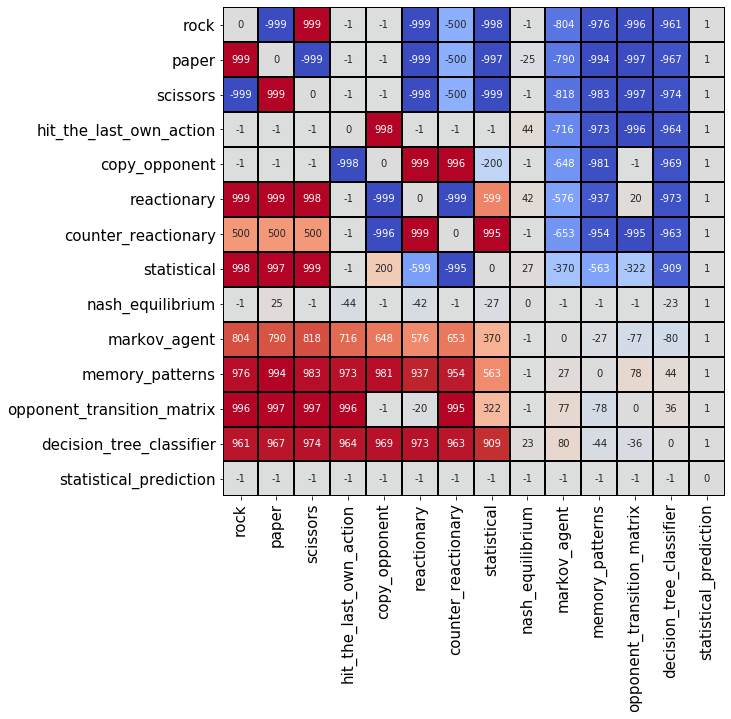

In [25]:
df_scores = pd.DataFrame(
    scores, 
    index=list_names, 
    columns=list_names,
)


plt.figure(figsize=(9, 9))
sns.heatmap(
    df_scores, annot=True, cbar=False, cmap='coolwarm', linewidths=1, linecolor='black', fmt="d"
)
plt.xticks(rotation=90, fontsize=15)
plt.yticks(fontsize=15)

# My Own Agents


Create your agent in the cell below, and save it to the **your_agent.py** file, and your agent will fight against all existing agents in this kernel

In [26]:
def evaluating(newName, currNames):
  # score matrix
  scores = np.zeros((len(currNames), 1), dtype=int)
  # list
  for idx in range(len(currNames)):
    _score = evaluate("rps", [newName, currNames[idx]], configuration={"episodeSteps": 1000})
    scores[idx, 0] = _score[0][0] if _score[0][0] else -1
  # plot
  df_scores = pd.DataFrame(scores, index=currNames, columns=["my own"],)

  plt.figure(figsize=(2, 10))
  sns.heatmap(
    df_scores, annot=True, cbar=False, 
    cmap="coolwarm", linewidths=1, linecolor="black", 
    fmt="d", vmin=-500, vmax=500,
  )
  plt.xticks(rotation=90, fontsize=15)
  plt.yticks(rotation=360, fontsize=15);

## 2D Transition Matrix

- Dado a última ação do oponente, prever a próxima ação

In [27]:
%%writefile submission/2d-transition-matrix.py
## https://www.kaggle.com/group16/rps-opponent-transition-matrix
import numpy as np
import pandas as pd
import random

T = np.zeros((3, 3))
P = np.zeros((3, 3))

# a1 is the action of the opponent 1 step ago
# a2 is the action of the opponent 2 steps ago
a1, a2 = None, None

def agent(observation, configuration):
    global T, P, a1, a2
    if observation.step > 1:
        a1 = observation.lastOpponentAction
        T[a2, a1] += 1
        P = np.divide(T, np.maximum(1, T.sum(axis=1)).reshape(-1, 1))
        a2 = a1
        if np.sum(P[a1, :]) == 1:
            return int((np.random.choice([0, 1, 2], p=P[a1, :]) + 1) % 3)
        else:
            return int(np.random.randint(3))
    else:
        if observation.step == 1:
            a2 = observation.lastOpponentAction
        return int(np.random.randint(3))

Overwriting submission/2d-transition-matrix.py


In [28]:
evaluate("rps", ['submission/2d-transition-matrix.py', list_agents[13]], 
  configuration={"episodeSteps": 1000}
)

[[1, None]]

In [29]:
# add agent
list_agents.append('submission/2d-transition-matrix.py')

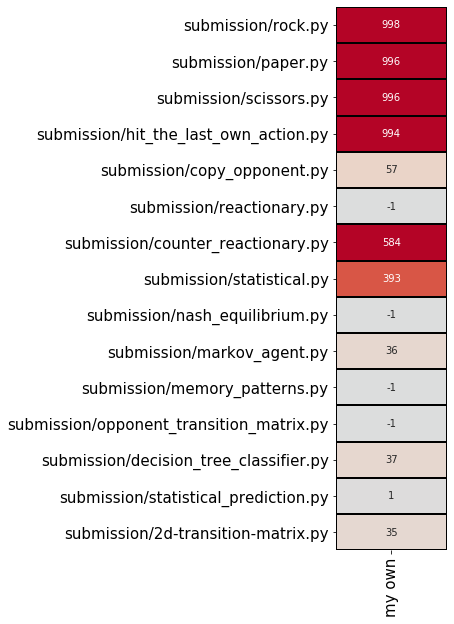

In [30]:
evaluating('submission/2d-transition-matrix.py', list_agents)

## 3D Transition Matrix

- Dado as duas últimas ações do oponente, prever a próxima ação

In [31]:
%%writefile submission/3d-transition-matrix.py
import numpy as np
import pandas as pd
import random

opt = 3
T = np.zeros((opt, opt, opt))
P = np.zeros((opt, opt, opt))

# transaction choice
t = [None, None, None]

def agent(observation, configuration):
    global T, P, t, opt
    if observation.step > 2:
        t[2] = observation.lastOpponentAction
        T[t[0], t[1], t[2]] += 1
        T0 = T[t[0]]
        P = np.divide(T0, np.maximum(1, T0.sum(axis=1)).reshape(-1, 1))
        t[0], t[1] = t[1], t[2]
        if np.sum(P[t[2], :]) == 1:
            return int((np.random.choice([0, 1, 2], p=P[t[2], :]) + 1) % opt)
        else:
            return int(np.random.randint(opt))
    else:
        # first play
        if observation.step == 1:
            t[0] = observation.lastOpponentAction
        # second play
        elif observation.step == 2:
            t[1] = observation.lastOpponentAction
        # random choice
        return int(np.random.randint(opt))

Overwriting submission/3d-transition-matrix.py


In [32]:
evaluate("rps", ['submission/3d-transition-matrix.py', list_agents[13]], 
  configuration={"episodeSteps": 1000}
)

[[1, None]]

In [33]:
# add agent
list_agents.append('submission/3d-transition-matrix.py')

Create the array for battle results

Visualize the result

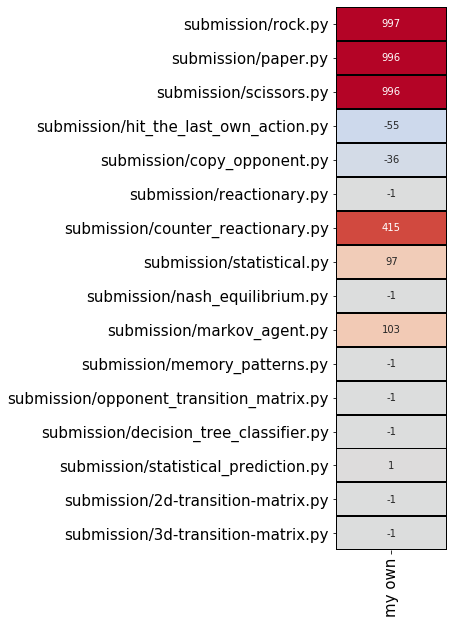

In [34]:
evaluating('submission/3d-transition-matrix.py', list_agents)

## nD Transition Matrix

- Dado as `n` últimas ações do oponente, prever a próxima ação

## 2D Counter Transition Matrix

- Dado minha penúltima ação - qual ação foi realizada pelo oponente?
- Armazena minha última ação, penúltima ação
- Prob de acordo com minha penúltima ação

In [35]:
%%writefile submission/2d-counter-tm.py
import numpy as np
import pandas as pd
import random

T = np.zeros((3, 3))

# a1 is the action of the opponent 1 step ago
# b1 is my action 1 step ago
# b2 is my action 2 steps ago
a1, b1, b2 = None, None, None

def agent(observation, configuration):
    global T, a1, b2, b1
    if observation.step > 2:
        a1 = observation.lastOpponentAction
        T[b2, a1] += 1
        P = np.divide(T, np.maximum(1, T.sum(axis=1)).reshape(-1, 1))
        b2 = b1
        if np.sum(P[b1, :]) == 1:
            b1 = int((np.random.choice([0, 1, 2], p=P[b1, :]) + 1) % 3)
            return b1
        else:
            return int(np.random.randint(3))
    else:
        b2 = b1
        b1 = int(np.random.randint(3))
        return b1

Overwriting submission/2d-counter-tm.py


In [36]:
evaluate("rps", ['submission/2d-counter-tm.py', 'submission/3d-transition-matrix.py'], 
  configuration={"episodeSteps": 1000}
)

[[0, 0]]

In [37]:
# add agent
list_agents.append('submission/2d-counter-tm.py')

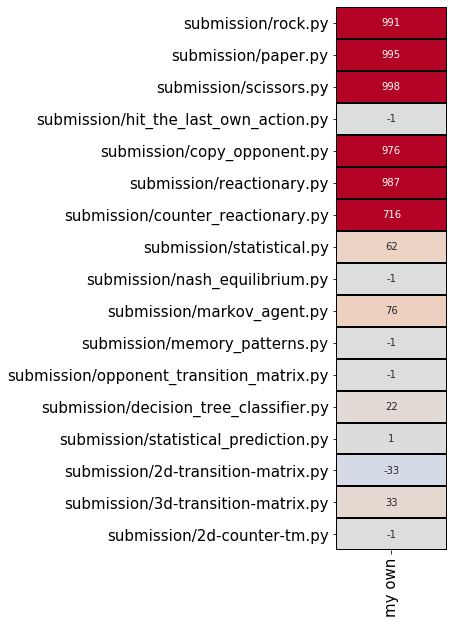

In [38]:
evaluating('submission/2d-counter-tm.py', list_agents)

## 3D Counter-Mix Transition Matrix

- Dado a minha última ação, e a ação do oponente - qual ação será realizada?
- Armazena minha última ação, penultima ação e ação anterior do oponente

In [39]:
%%writefile submission/3d-counter-mix-tm.py
import numpy as np
import pandas as pd
import random

T = np.zeros((3, 3, 3))

# a1 is the action of the opponent 1 step ago
# a1 is the action of the opponent 2 step ago
# b1 is my action 1 step ago
# b2 is my action 2 steps ago
a1, a2, b1, b2 = None, None, None, None

def agent(observation, configuration):
    global T, a1, a2, b2, b1
    if observation.step > 2:
        # last play
        a1 = observation.lastOpponentAction
        # increment
        T[a2, b2, a1] += 1
        # matrix, based on his a2 action
        Tb = T[a2]
        P = np.divide(Tb, np.maximum(1, Tb.sum(axis=1)).reshape(-1, 1))
        # update b2 and a2
        b2, a2 = b1, a1
        if np.sum(P[b1, :]) == 1:
            b1 = int((np.random.choice([0, 1, 2], p=P[b1, :]) + 1) % 3)
            return b1
        else:
            return int(np.random.randint(3))
    else:
        b2 = b1
        a2 = observation.lastOpponentAction if observation.step > 1 else None
        b1 = int(np.random.randint(3))
        return b1

Overwriting submission/3d-counter-mix-tm.py


In [40]:
evaluate("rps", ['submission/3d-counter-mix-tm.py', 'submission/3d-transition-matrix.py'], 
  configuration={"episodeSteps": 1000}
)

[[47.0, -47.0]]

In [41]:
# add agent
list_agents.append('submission/3d-counter-mix-tm.py')

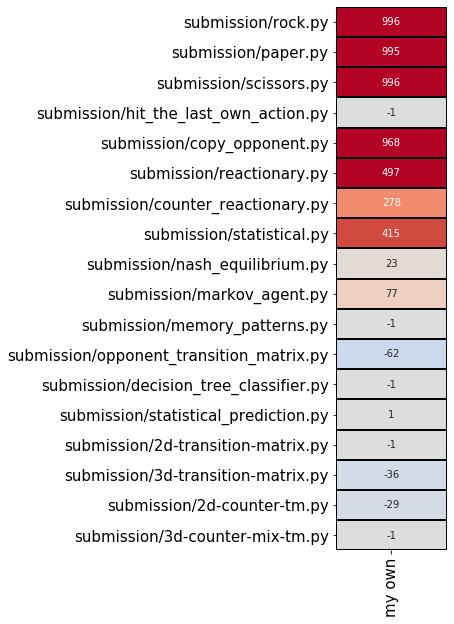

In [42]:
evaluating('submission/3d-counter-mix-tm.py', list_agents)

## Multi Transition Matrix

- Combinar as estratégias de Transition Matrix
- 2D TM, 3D TM, 2D CTM, e 3D CMTM
- Realizar uma escolha, baseado em probabilidade, na saída das estratégias
     1. Escolher a inteligência com maior probabilidade baseado em vitórias, quais estratégias venceram mais

In [43]:
%%writefile multi-transition-matrix.py
import numpy as np
import pandas as pd
import random

## -------------------------------------------------------------------------
class dTransitionMatrix:
    # transition matrix
    T = None
    # a1 is the action of the opponent 1 step ago
    # a2 is the action of the opponent 2 steps ago
    a1 = None
    a2 = None

    def __init__(self):
        self.T = np.zeros((3, 3))
        self.a1, self.a2 = None, None

    def run(self, observation, configuration):
        if observation.step > 1:
            self.a1 = observation.lastOpponentAction
            self.T[self.a2, self.a1] += 1
            P = np.divide(self.T, np.maximum(1, self.T.sum(axis=1)).reshape(-1, 1))
            self.a2 = self.a1
            if np.sum(P[self.a1, :]) == 1:
                return int((np.random.choice([0, 1, 2], p=P[self.a1, :]) + 1) % 3)
            else:
                return int(np.random.randint(3))
        else:
            if observation.step == 1:
                self.a2 = observation.lastOpponentAction
            return int(np.random.randint(3))

## -------------------------------------------------------------------------
class ndTransitionMatrix:

    T = None
    # transaction choice
    t = None

    def __init__(self):
        self.T = np.zeros((3, 3, 3))
        self.t = [None, None, None]

    def run(self, observation, configuration):
        if observation.step > 2:
            self.t[2] = observation.lastOpponentAction
            self.T[self.t[0], self.t[1], self.t[2]] += 1
            T0 = self.T[self.t[0]]
            P = np.divide(T0, np.maximum(1, T0.sum(axis=1)).reshape(-1, 1))
            self.t[0], self.t[1] = self.t[1], self.t[2]
            if np.sum(P[self.t[2], :]) == 1:
                return int((np.random.choice([0, 1, 2], p=P[self.t[2], :]) + 1) % 3)
            else:
                return int(np.random.randint(3))
        else:
            # first play
            if observation.step == 1:
                self.t[0] = observation.lastOpponentAction
            # second play
            elif observation.step == 2:
                self.t[1] = observation.lastOpponentAction
            # random choice
            return int(np.random.randint(3))

## -------------------------------------------------------------------------
class dCounterTransitionMatrix:

    T = None
    # a1 is the action of the opponent 1 step ago
    # b1 is my action 1 step ago
    # b2 is my action 2 steps ago
    a1 = None
    b1 = None
    b2 = None

    def __init__(self):
        self.T = np.zeros((3, 3))
        self.a1, self.b1, self.b2 = None, None, None

    def run(self, observation, configuration):
        if observation.step > 2:
            self.a1 = observation.lastOpponentAction
            self.T[self.b2, self.a1] += 1
            P = np.divide(self.T, np.maximum(1, self.T.sum(axis=1)).reshape(-1, 1))
            self.b2 = self.b1
            if np.sum(P[self.b1, :]) == 1:
                self.b1 = int((np.random.choice([0, 1, 2], p=P[self.b1, :]) + 1) % 3)
                return self.b1
            else:
                return int(np.random.randint(3))
        else:
            self.b2 = self.b1
            self.b1 = int(np.random.randint(3))
            return self.b1

## -------------------------------------------------------------------------
class multiAgent:
    
    agents = None
    score = None
    lastAction = None

    def __init__(self, agents):
        self.agents = agents
        self.score      = np.zeros(len(agents))
        self.lastAction = np.zeros(len(agents))

    def checkResult(self, lastOpponentAction):
        for key in range(len(self.agents)):
            myLast = self.lastAction[key]
            if (lastOpponentAction + 1) % 3 == myLast:
                self.score[key] += 1

    def run(self, observation, configuration):
        # calculate actions
        for key, agent in enumerate(self.agents):
            self.lastAction[key] = agent.run(observation, configuration)
        # check action step
        if observation.step > 1:
            # validate results
            self.checkResult(observation.lastOpponentAction)
            # calculate probabilities
            if sum(multi.score) > 1:
                P = np.divide(multi.score, sum(multi.score))
                key, maxP = 0, -1
                for i, p in enumerate(P):
                    if maxP < p:
                        key, maxP = i, p
                return int(self.lastAction[key])
            # random action
            return int(np.random.randint(3))
        else:
            # random action
            return int(self.lastAction[0])

## -------------------------------------------------------------------------
agents = [
    dTransitionMatrix(),
    ndTransitionMatrix(),
    dCounterTransitionMatrix()
]
multi = multiAgent(agents)

def agent(observation, configuration):
    global multi
    return multi.run(observation, configuration)

Writing multi-transition-matrix.py


In [44]:
evaluate("rps", ['submission/multi-transition-matrix.py', 'submission/2d-counter-tm.py'], 
  configuration={"episodeSteps": 1000}
)

[[23.0, -23.0]]

In [45]:
# add agent
list_agents.append('submission/multi-transition-matrix.py')

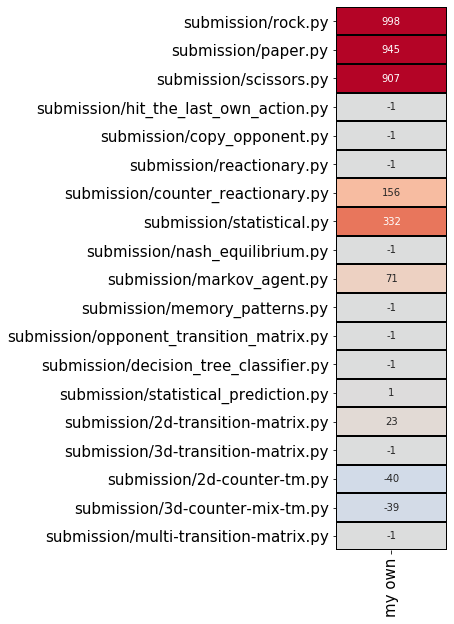

In [46]:
evaluating('submission/multi-transition-matrix.py', list_agents)

## Multi Transition Matrix 2

- Combinar as estratégias de Transition Matrix
- 2D TM, 3D TM, 2D CTM, Markov, e Memory Pattern
- Realizar uma escolha, baseado em probabilidade, na saída das estratégias
     1. Escolher a inteligência com maior probabilidade baseado em vitórias

In [80]:
%%writefile submission/multi-transition-matrix-2.py
import numpy as np
import pandas as pd
import random

import collections
from kaggle_environments.envs.rps.utils import get_score

## -------------------------------------------------------------------------
class dTransitionMatrix:
    # transition matrix
    T = None
    # a1 is the action of the opponent 1 step ago
    # a2 is the action of the opponent 2 steps ago
    a1 = None
    a2 = None

    def __init__(self):
        self.T = np.zeros((3, 3))
        self.a1, self.a2 = None, None

    def run(self, observation, configuration):
        if observation.step > 1:
            self.a1 = observation.lastOpponentAction
            self.T[self.a2, self.a1] += 1
            P = np.divide(self.T, np.maximum(1, self.T.sum(axis=1)).reshape(-1, 1))
            self.a2 = self.a1
            if np.sum(P[self.a1, :]) == 1:
                return int((np.random.choice([0, 1, 2], p=P[self.a1, :]) + 1) % 3)
            else:
                return int(np.random.randint(3))
        else:
            if observation.step == 1:
                self.a2 = observation.lastOpponentAction
            return int(np.random.randint(3))

## -------------------------------------------------------------------------
class ndTransitionMatrix:

    T = None
    # transaction choice
    t = None

    def __init__(self):
        self.T = np.zeros((3, 3, 3))
        self.t = [None, None, None]

    def run(self, observation, configuration):
        if observation.step > 2:
            self.t[2] = observation.lastOpponentAction
            self.T[self.t[0], self.t[1], self.t[2]] += 1
            T0 = self.T[self.t[0]]
            P = np.divide(T0, np.maximum(1, T0.sum(axis=1)).reshape(-1, 1))
            self.t[0], self.t[1] = self.t[1], self.t[2]
            if np.sum(P[self.t[2], :]) == 1:
                return int((np.random.choice([0, 1, 2], p=P[self.t[2], :]) + 1) % 3)
            else:
                return int(np.random.randint(3))
        else:
            # first play
            if observation.step == 1:
                self.t[0] = observation.lastOpponentAction
            # second play
            elif observation.step == 2:
                self.t[1] = observation.lastOpponentAction
            # random choice
            return int(np.random.randint(3))

## -------------------------------------------------------------------------
class dCounterTransitionMatrix:

    T = None
    # a1 is the action of the opponent 1 step ago
    # b1 is my action 1 step ago
    # b2 is my action 2 steps ago
    a1 = None
    b1 = None
    b2 = None

    def __init__(self):
        self.T = np.zeros((3, 3))
        self.a1, self.b1, self.b2 = None, None, None

    def run(self, observation, configuration):
        if observation.step > 2:
            self.a1 = observation.lastOpponentAction
            self.T[self.b2, self.a1] += 1
            P = np.divide(self.T, np.maximum(1, self.T.sum(axis=1)).reshape(-1, 1))
            self.b2 = self.b1
            if np.sum(P[self.b1, :]) == 1:
                self.b1 = int((np.random.choice([0, 1, 2], p=P[self.b1, :]) + 1) % 3)
                return self.b1
            else:
                return int(np.random.randint(3))
        else:
            self.b2 = self.b1
            self.b1 = int(np.random.randint(3))
            return self.b1

## -------------------------------------------------------------------------
class Markov:

    table = None
    action_seq = None

    def __init__(self):
        self.action_seq = []
        self.table = collections.defaultdict(lambda: [1, 1, 1])

    def run(self, observation, configuration):
        k = 2
        if observation.step % 250 == 0: # refresh table every 250 steps
            self.action_seq, self.table = [], collections.defaultdict(lambda: [1, 1, 1])
        if len(self.action_seq) <= 2 * k + 1:
            action = int(np.random.randint(3))
            if observation.step > 0:
                self.action_seq.extend([observation.lastOpponentAction, action])
            else:
                self.action_seq.append(action)
            return action
        # update table
        key = ''.join([str(a) for a in self.action_seq[:-1]])
        self.table[key][observation.lastOpponentAction] += 1
        # update action seq
        self.action_seq[:-2] = self.action_seq[2:]
        self.action_seq[-2] = observation.lastOpponentAction
        # predict opponent next move
        key = ''.join([str(a) for a in self.action_seq[:-1]])
        if observation.step < 500:
            next_opponent_action_pred = np.argmax(self.table[key])
        else:
            # add stochasticity for second part of the game
            scores = np.array(self.table[key])
            next_opponent_action_pred = np.random.choice(3, p=scores/scores.sum()) 
        # make an action
        action = (next_opponent_action_pred + 1) % 3
        # if high probability to lose -> let's surprise our opponent with sudden change of our strategy
        if observation.step > 900:
            action = next_opponent_action_pred
        self.action_seq[-1] = action
        return int(action)

## -------------------------------------------------------------------------
class MemoryPatterns:
    # how many steps in a row are in the pattern (multiplied by two)
    memory_length = None
    # current memory of the agent
    current_memory = None
    # list of memory patterns
    memory_patterns = None

    def __init__(self):
        self.memory_length = 6
        self.current_memory = []
        self.memory_patterns = []


    def find_pattern(self, memory):
        """ find appropriate pattern in memory """
        for pattern in self.memory_patterns:
            actions_matched = 0
            for i in range(self.memory_length):
                if pattern["actions"][i] == memory[i]:
                    actions_matched += 1
                else:
                    break
            # if memory fits this pattern
            if actions_matched == self.memory_length:
                return pattern
        # appropriate pattern not found
        return None

    def run(self, obs, conf):
        """ your ad here """
        # if it's not first step, add opponent's last action to agent's current memory
        if obs.step > 0:
            self.current_memory.append(obs.lastOpponentAction)
        # if length of current memory is bigger than necessary for a new memory pattern
        if len(self.current_memory) > self.memory_length:
            # get momory of the previous step
            previous_step_memory = self.current_memory[:self.memory_length]
            previous_pattern = self.find_pattern(previous_step_memory)
            if previous_pattern == None:
                previous_pattern = {
                    "actions": previous_step_memory.copy(),
                    "opp_next_actions": [
                        {"action": 0, "amount": 0, "response": 1},
                        {"action": 1, "amount": 0, "response": 2},
                        {"action": 2, "amount": 0, "response": 0}
                    ]
                }
                self.memory_patterns.append(previous_pattern)
            for action in previous_pattern["opp_next_actions"]:
                if action["action"] == obs.lastOpponentAction:
                    action["amount"] += 1
            # delete first two elements in current memory (actions of the oldest step in current memory)
            del self.current_memory[:2]
        my_action = random.randint(0, 2)
        pattern = self.find_pattern(self.current_memory)
        if pattern != None:
            my_action_amount = 0
            for action in pattern["opp_next_actions"]:
                # if this opponent's action occurred more times than currently chosen action
                # or, if it occured the same amount of times, choose action randomly among them
                if (action["amount"] > my_action_amount or
                        (action["amount"] == my_action_amount and random.random() > 0.5)):
                    my_action_amount = action["amount"]
                    my_action = action["response"]
        self.current_memory.append(my_action)
        return int(my_action)

## -------------------------------------------------------------------------
class multiAgent:
    
    agents = None
    score = None
    lastAction = None

    def __init__(self, agents):
        self.agents = agents
        self.score      = np.zeros(len(agents))
        self.lastAction = np.zeros(len(agents))

    def checkResult(self, lastOpponentAction):
        for key in range(len(self.agents)):
            myLast = self.lastAction[key]
            if (lastOpponentAction + 1) % 3 == myLast:
                self.score[key] += 1

    def run(self, observation, configuration):
        # calculate actions
        for key, agent in enumerate(self.agents):
            self.lastAction[key] = agent.run(observation, configuration)
        # check action step
        if observation.step > 1:
            # validate results
            self.checkResult(observation.lastOpponentAction)
            # calculate probabilities
            if sum(multi.score) > 1:
                P = np.divide(multi.score, sum(multi.score))
                key, maxP = 0, -1
                for i, p in enumerate(P):
                    if maxP < p:
                        key, maxP = i, p
                return int(self.lastAction[key])
            # random action
            return int(np.random.randint(3))
        else:
            # random action
            return int(self.lastAction[0])

## -------------------------------------------------------------------------
agents = [
    dTransitionMatrix(),
    ndTransitionMatrix(),
    dCounterTransitionMatrix(),
    Markov(),
    MemoryPatterns()
]
multi = multiAgent(agents)

def agent(observation, configuration):
    global multi
    return multi.run(observation, configuration)

Overwriting submission/multi-transition-matrix-2.py


In [81]:
evaluate("rps", ['submission/multi-transition-matrix-2.py', 'submission/2d-counter-tm.py'], 
  configuration={"episodeSteps": 1000}
)

[[-49.0, 49.0]]

In [77]:
# add agent
list_agents.append('submission/multi-transition-matrix-2.py')

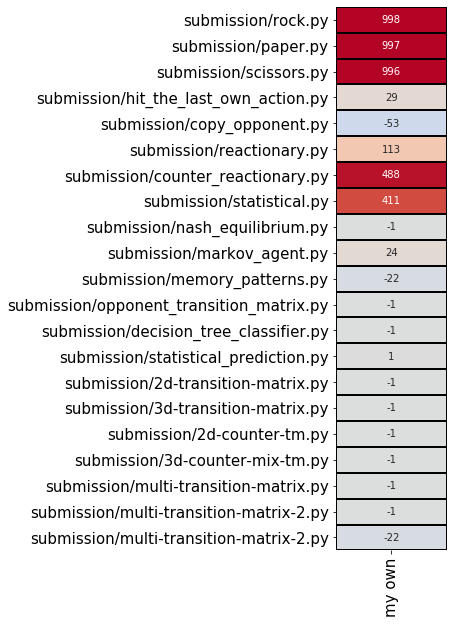

In [82]:
evaluating('submission/multi-transition-matrix-2.py', list_agents)